### Facsimile inversion 

In [1]:
import numpy as np
import itertools as it
# from Comm.utils import iterative_solve_eta as itsol
import sys
sys.path.append('../Comm/')
from utils import iterative_solve_eta as itsol
import matplotlib.pyplot as plt
from scipy.special import softmax

torch_available = False
try :
    import torch as torch
    dtype = torch.double
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print('Device: GPU')
    else:
        device = torch.device("cpu")
        print('Device: CPU')
    torch_available = True
    print('Pytorch available')
except ImportError:
    print('Pytorch not available')

petsc4py_available = False
try :
    import petsc4py
    petsc4py.init()
    from petsc4py import PETSc
    petsc4py_available = True
    print('Petsc4py available')
except ImportError:
    print('Petsc4py not available')

scipy_sparse_available = False
try :
    import scipy.sparse as sparse
    scipy_sparse_available = True
    print('Scipy sparse available')
except ImportError:
    print('Scipy sparse not available')
    


Device: GPU
Pytorch available
Petsc4py available
Scipy sparse available


### Tip
To make available the module petsc4py in the Ullyses cluster do the following:
```
module load gnu8 openmpi3 openblas scalapack cuda/11.8 phdf5 python3/3.8
pip install --user Cython==0.29.32
pip install --user mpi4py
export PETSC_CONFIGURE_OPTIONS=' --with-cuda=1 --with-debugging=0'
pip install --user petsc # this will take a while
pip install --user petsc4py
```

### Main problem 
Solve the following:
$$
\begin{align*}
(\mathbf{1} - \gamma \mathbf{T})  \eta &=  \rho
\end{align*}
$$
### Variables
$$
\begin{align*}
\text{pi} &\to \pi(a\ m'\ |\ m\ y)\\
\text{PObs\char`_lim} &\to f(y\ |\ m\ s)\\
\text{gamma} &\to \gamma \to \text{Discount factor}\\
\text{rho0} &\to \rho \to \text{Distribution of the initial position of the agent}\\
\text{Lx, Ly, Lx0, Ly0} &\to \text{Environment setting}\\
\text{find\char`_range} &\to \text{Radius threshold for reach the price}
\end{align*}
$$

## Utilities functions

In [2]:
clip = lambda x, l, u: l if x < l else u if x > u else x

def populate_Tsm_sm(M,Lx,Ly,p_a_mu_m_xy,Tsm_sm):
    # Action Order
    # left, right, up, down
    
    # tuples to be populated
    #      T indices : "left / right / up / down"
    #      (m', y', x', m, y, x)
    #      pi indices : "left_act / ... "
    #      (m', a, m, y, x)
    for im_new in range(M):
        
        left = [ (im_new, iy, clip(ix-1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for l, la in zip(left, left_act):
            Tsm_sm[l] += p_a_mu_m_xy[la]
        
        right = [ (im_new, iy, clip(ix+1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for r, ra in zip(right, right_act):
            Tsm_sm[r] += p_a_mu_m_xy[ra]
    
        up = [ (im_new, clip(iy+1, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for u, ua in zip(up, up_act):
            Tsm_sm[u] += p_a_mu_m_xy[ua]
        
        down = [ (im_new, clip(iy-1, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for d, da in zip(down, down_act):
            Tsm_sm[d] += p_a_mu_m_xy[da]
    # return Tsm_sm

def solution_test(eta,T,rho,gamma,plot=False):
    sol = (np.eye(T.shape[0]) - gamma * T) @ eta
    if plot:
        # title of the plot rho - (1 - gamma * T) @ eta put in latex style
        plt.title(r'$\mathbf{\rho} - (\mathbf{1} - \gamma \mathbf{T}) \mathbf{\eta} = 0 $')
        plt.plot(sol-rho)
        plt.show()
    return np.allclose(sol,rho)
    

## Functions to the $\eta$ with different libraries

In [34]:
def eta_petsc(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system for eta using PETSc
    """
    # Get non-zero indices from Tsm_sm_matrix per row 
    non_zeros_in_row = [np.nonzero(Tsm_sm_matrix[i,:])[0] for i in range(Tsm_sm_matrix.shape[0])]
    count_non_zeros_in_row = np.array([len(non_zeros_in_row[i]) for i in range(len(non_zeros_in_row))],dtype=np.int32)

    # print('Number of non-zero elements per row: ', np.sum(count_non_zeros_in_row))

    # Create PETSc matrix
    A = PETSc.Mat()
    A.createAIJ([M*Lx*Ly,M*Lx*Ly], nnz=count_non_zeros_in_row)

    # Fill PETSc matrix
    non_zeros_Tsm = np.transpose(np.nonzero(Tsm_sm_matrix))
    for index in non_zeros_Tsm:
        A.setValues(index[0],index[1],Tsm_sm_matrix[index[0],index[1]])
    
    A.assemblyBegin()
    A.assemblyEnd()

    # eye matrix with PETSc
    ones = PETSc.Mat()
    ones.createAIJ(size=(M*Lx*Ly,M*Lx*Ly), nnz=1)
    for i in range(M*Lx*Ly):
        ones.setValues(i,i,1.0)

    ones.assemblyBegin()
    ones.assemblyEnd()

    # matrix_A =  I - gamma * T
    A.aypx(-gamma,ones)

    # print('Matrix A assembled', A.size)
    # print(A.getInfo())
    
    x, b =  PETSc.Vec().createSeq(M*Lx*Ly), PETSc.Vec().createSeq(M*Lx*Ly)
    b.setValues(np.arange(rho0.shape[0],dtype=np.int32),rho0)
    b.assemble()

    # Start the solver
    ksp = PETSc.KSP().create()
    ksp.setOperators(A)
    ksp.setType(PETSc.KSP.Type.RICHARDSON)
    # ksp.setType('bcgs')
    # ksp.setConvergenceHistory()
    # ksp.getPC().setType('none')
    ksp.getPC().setType(PETSc.PC.Type.JACOBI)
    # ksp.setFromOptions()
    ksp.setTolerances(rtol=1e-10)
    # ksp.setInitialGuessNonzero(True)

    ksp.setUp()

    ksp.solve(b, x)

    # residuals = ksp.getConvergenceHistory()
    # plt.semilogy(residuals)
    # plt.show()

    ksp.destroy()
    A.destroy()
    ones.destroy()
    b.destroy()

    eta = x.getArray()
    x.destroy()

    return eta

# inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=eta_petsc)
# print(type(inv_sol), inv_sol.shape, inv_sol.dtype, inv_sol.min(), inv_sol.max())
# plt.imshow(inv_sol.reshape(M,Ly,Lx)[0])
# plt.colorbar()
# plt.show()
# print('Solution test: ', solution_test(inv_sol,T,rho0,gamma))

# inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=eta_torch_sol)
# print(type(inv_sol), inv_sol.shape, inv_sol.dtype, inv_sol.min(), inv_sol.max())
# plt.imshow(inv_sol.reshape(M,Ly,Lx)[0])
# plt.colorbar()
# plt.show()

# print('Solution test: ', solution_test(inv_sol,T,rho0,gamma))


In [4]:

def eta_numpy(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Invert a matrix using numpy
    """
    to_invert = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    inverted = np.linalg.inv(to_invert)
    new_eta = inverted @ rho0

    return new_eta

def eta_numpy_sol(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system
    """
    mat_A = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    new_eta = np.linalg.solve(mat_A,rho0)

    return new_eta

def eta_torch(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Invert a matrix using torch
    """
    Tsm_sm_matrix_torch = torch.from_numpy(Tsm_sm_matrix).type(dtype).to(device)

    rho0_torch = torch.from_numpy(rho0).type(dtype).to(device) 

    to_invert = torch.eye(M*Ly*Lx,dtype=dtype,device=device) - gamma * Tsm_sm_matrix_torch
    inverted = torch.torch.linalg.inv(to_invert)
    new_eta = inverted @ rho0_torch

    new_eta = new_eta.cpu().numpy()

    return new_eta

def eta_torch_sol(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system using torch
    """
    Tsm_sm_matrix_torch = torch.from_numpy(Tsm_sm_matrix).type(dtype).to(device)

    rho0_torch = torch.from_numpy(rho0).type(dtype).to(device) 

    A_mat = torch.eye(M*Ly*Lx,dtype=dtype,device=device) - gamma * Tsm_sm_matrix_torch
    new_eta = torch.linalg.solve(A_mat,rho0_torch)

    new_eta = new_eta.cpu().numpy()

    return new_eta

def eta_scipy_sparce_solve(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0):
    """
    Solve linear system using scipy sparce
    """
    Tsm_sm_matrix_sparce = sparse.csr_matrix(Tsm_sm_matrix)
    to_invert = sparse.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix_sparce
    new_eta = sparse.linalg.spsolve(to_invert,rho0)

    return new_eta


## Solve the problem

In [5]:


def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=eta_numpy, verbose=False):
    """
    This function should solve the following:
    --> New_eta = (1 - gamma T)^-1 rho
    """
    # O = Observations
    # M = Memory
    # A = Actions
    O, M, A = pi.shape
    # L = Dimension of the environment
    L = Lx * Ly
    new_eta = np.zeros(M*L)
    
    # PY has size ~ 10^5
    PY = PObs_lim.reshape(O, M, Ly, Lx)
    # PY has size ~ 10^2
    PAMU = pi.reshape(O, M, M, A//M)
    
    p_a_mu_m_xy = np.einsum( 'omyx, omna -> anmyx', PY, PAMU)
    # T [ s'm'  sm] = sum_a, mu p(s'm' | sm a mu) p(a mu | sm)
    #               = sum_a, mu p(s'm' | sm a mu) sum_y f(y | s) pi(a mu | y m)
    
    # Tsm_sm has size ~ 10^5 x 10^5 or more
    Tsm_sm = np.zeros( (M, Ly, Lx, M, Ly, Lx) )

    if verbose:
        print("pi shape:",pi.shape)
        print("new_eta shape:",new_eta.shape)
        print("PY shape:",PY.shape, "PAMU shape:",PAMU.shape)
        print("p_a_mu_m_xy shape:",p_a_mu_m_xy.shape)
        print("Tsm_sm shape:",Tsm_sm.shape,"size:",Tsm_sm.size)
    
    #  Populated of Tsm_sm
    populate_Tsm_sm(M,Lx,Ly,p_a_mu_m_xy,Tsm_sm)
    
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    
    All = slice(None)
    for yx_found in yx_founds:
        # print("yx_found:",yx_found)
        # all transitions starting from the source do not go anywhere
        ls = (All, yx_found[0], yx_found[1], All, All, All)
        Tsm_sm[ls] = 0
        # all transitions ending in the source stop the episode
        ls = (All, All, All, All, yx_found[0], yx_found[1])
        Tsm_sm[ls] = 0
    
    Tsm_sm_matrix = np.reshape(Tsm_sm, (M*Ly*Lx, M*Ly*Lx))
    
    if verbose:
        print("number of non-zeros in Tsm_sm_matrix:",np.count_nonzero(Tsm_sm_matrix != 0))
        print("number of     zeros in Tsm_sm_matrix:",np.count_nonzero(Tsm_sm_matrix == 0))
        plt.imshow(Tsm_sm_matrix)
        plt.show()
        
    new_eta = func_eta(Tsm_sm_matrix,gamma,M,Lx,Ly,rho0)
    
    return new_eta, Tsm_sm_matrix

## TEST

pi shape: (2, 2, 8)
new_eta shape: (2970,)
PY shape: (2, 2, 45, 33) PAMU shape: (2, 2, 2, 4)
p_a_mu_m_xy shape: (4, 2, 2, 45, 33)
Tsm_sm shape: (2, 45, 33, 2, 45, 33) size: 8820900
number of non-zeros in Tsm_sm_matrix: 23456
number of     zeros in Tsm_sm_matrix: 8797444


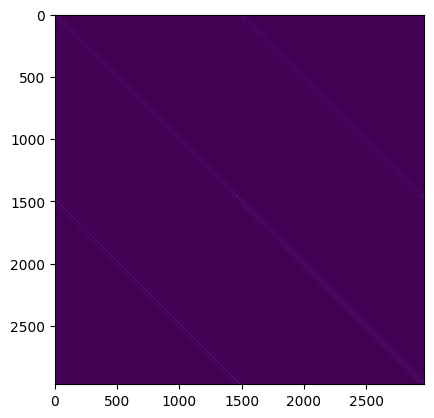

In [6]:


M = 2 # O(10) 
O = 2 # 2/3
dim_factor = 3
Lx = 11 * dim_factor # O(100)-O(1000)
Ly = 15 * dim_factor # O(100)-O(1000)        
a_size = 4

# np.random.seed(33+33)

pi = softmax( np.random.rand(O,M,M*a_size), 2)

PObs_lim = np.random.rand(O, M*Lx*Ly)
PObs_lim[1] = 1-PObs_lim[0]
Lx0 = 5
Ly0 = 7
rho0 = np.random.rand(M*Lx*Ly)
rho0[Lx:] = 0
rho0 /= np.sum(rho0)
eta0 = np.random.rand(M*Lx*Ly)
gamma = 0.99
find_range = 2.1
tol = 1e-8

inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, verbose=True)
iter_sol = itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)


## Benchmarking of the solvers

In [7]:
solvers = [eta_numpy,eta_numpy_sol,eta_torch, eta_torch_sol,eta_scipy_sparce_solve, eta_petsc]
name_solvers = [ "Numpy","Numpy Sol","Torch", "Torch Sol","ScipySP", "Petsc"]

for solver, name_solver in zip(solvers, name_solvers):
    print("Method: {:>12}".format(name_solver), end=" ")
    %timeit solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solver, verbose=False)

print("\nIterative Solution", end=" ")

%timeit itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

Method:        Numpy 3.95 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:    Numpy Sol 1.23 s ± 322 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:        Torch 2.24 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:    Torch Sol 760 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:      ScipySP 289 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:        Petsc 460 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Iterative Solution 363 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
solvers = [eta_scipy_sparce_solve, eta_petsc]
name_solvers = [ "ScipySP", "Petsc"]

for solver, name_solver in zip(solvers, name_solvers):
    print("Method: {:>12}".format(name_solver), end=" ")
    %timeit solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solver, verbose=False)

print("\nIterative Solution", end=" ")

%timeit itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

Method:      ScipySP 294 ms ± 48.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method:        Petsc 720 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Iterative Solution 358 ms ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Profiling

In [9]:
# Profiler line by line
%load_ext line_profiler
# %lprun?

In [10]:
%lprun -f solve_eta solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)

Timer unit: 1e-09 s

Total time: 3.17095 s
File: /tmp/ipykernel_25315/3914220988.py
Function: solve_eta at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=eta_numpy, verbose=False):
     2                                               """
     3                                               This function should solve the following:
     4                                               --> New_eta = (1 - gamma T)^-1 rho
     5                                               """
     6                                               # O = Observations
     7                                               # M = Memory
     8                                               # A = Actions
     9         1       4900.0   4900.0      0.0      O, M, A = pi.shape
    10                                               # L = Dimension of the environment
    1

In [11]:
%lprun -f itsol  itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)

Timer unit: 1e-09 s

Total time: 0.347581 s
File: /home/frodox/MHPC/Project/Finite-Memory-Controller/FSC/FSC_NB/../Comm/utils.py
Function: iterative_solve_eta at line 122

Line #      Hits         Time  Per Hit   % Time  Line Contents
   122                                           def iterative_solve_eta(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range):
   123         1       1100.0   1100.0      0.0      max_it = 10000
   124         1      52600.0  52600.0      0.0      eta = eta0.copy()
   125         1      74700.0  74700.0      0.0      new_eta = np.zeros(eta.shape)
   126         1       2900.0   2900.0      0.0      O, M, A = pi.shape
   127         1       1800.0   1800.0      0.0      L = eta.shape[0] // M
   128         1       1000.0   1000.0      0.0      tol2 = 0.
   129         1       1000.0   1000.0      0.0      if (gamma < 1.):
   130         1       1500.0   1500.0      0.0          tol2 = tol/(1-gamma)*tol/(1-gamma)
   131                       

## Comparison of the results

In [12]:
memory = 0

print("Shape   iter_sol:", iter_sol.shape[0],
          "max: {:.4f} min: {:.4f}".format(np.max(iter_sol), np.min(iter_sol)))

for solver, name_solver in zip(solvers, name_solvers):
    inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solver)
    print("Shape {:>12}: {:} max: {:.4f} min: {:.4f}".format(name_solver, inv_sol.shape[0], np.max(inv_sol), np.min(inv_sol)), end=" ")  
    print("|| Passing test of solver:",solution_test(inv_sol,T,rho0,gamma), end=" ")
    print("|| Diff from iter_sol: {:.8f}".format(np.sum(np.abs(iter_sol-inv_sol))))
print("-"*50)
print("Diff between solvers")        
for i in range(len(solvers)):
    inv_sol_i, T_i = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solvers[i])
    for j in range(i+1,len(solvers)):
        inv_sol_j, T_j = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solvers[j])
        print("Difference between {:>12} and {:>12}: {:.5e}".format(name_solvers[i], name_solvers[j], np.sum(np.abs(inv_sol_i-inv_sol_j)))) 

Shape   iter_sol: 2970 max: 0.2582 min: 0.0000
Shape        Numpy: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322135
Shape    Numpy Sol: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322135
Shape        Torch: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322135
Shape    Torch Sol: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322135
Shape      ScipySP: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322135
Shape        Petsc: 2970 max: 0.2582 min: 0.0000 || Passing test of solver: True || Diff from iter_sol: 0.01322136
--------------------------------------------------
Diff between solvers
Difference between        Numpy and    Numpy Sol: 3.23723e-14
Difference between        Numpy and        Torch: 8.18438e-14
Difference between        Numpy and    Torch Sol: 5.35188e-14
Diffe

Test:        Numpy
Shape inv_sol: (2970,) max: 0.25824498176854227 min: 0.0


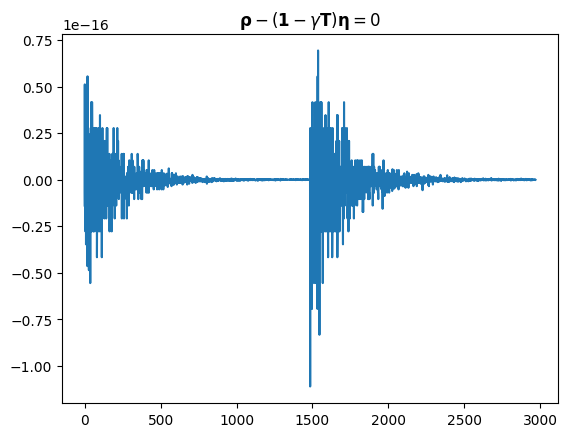

Passing test of solver True


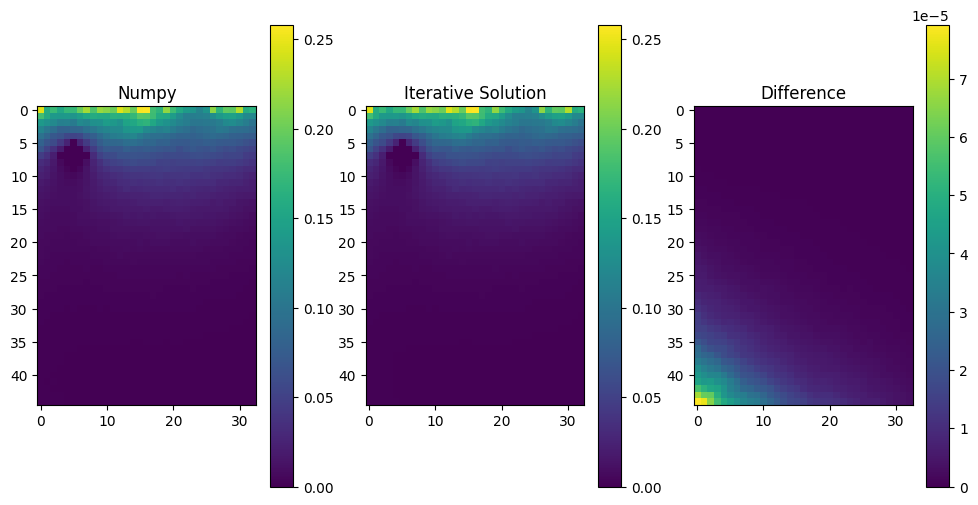

Test:    Numpy Sol
Shape inv_sol: (2970,) max: 0.25824498176854216 min: 0.0


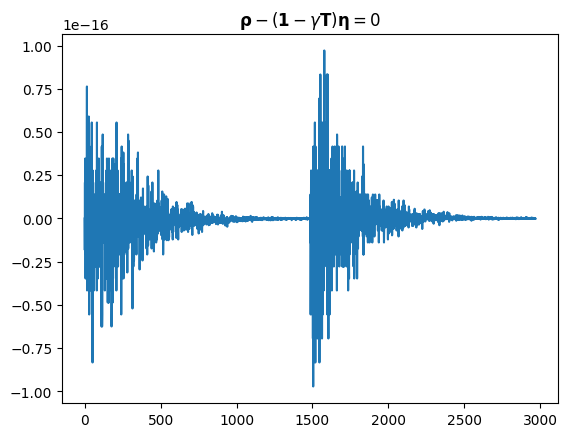

Passing test of solver True


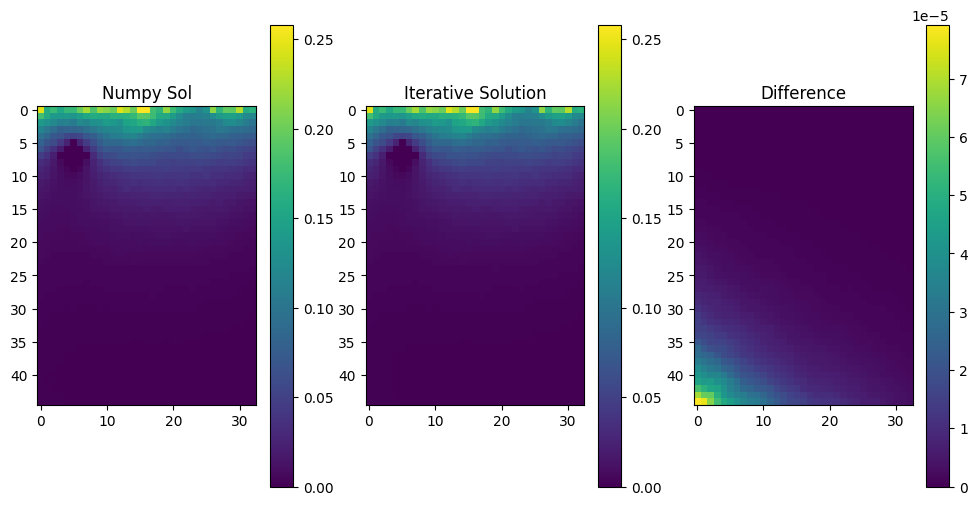

Test:        Torch
Shape inv_sol: (2970,) max: 0.25824498176854205 min: 0.0


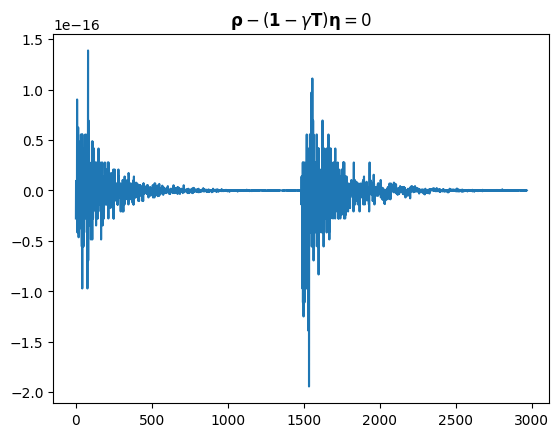

Passing test of solver True


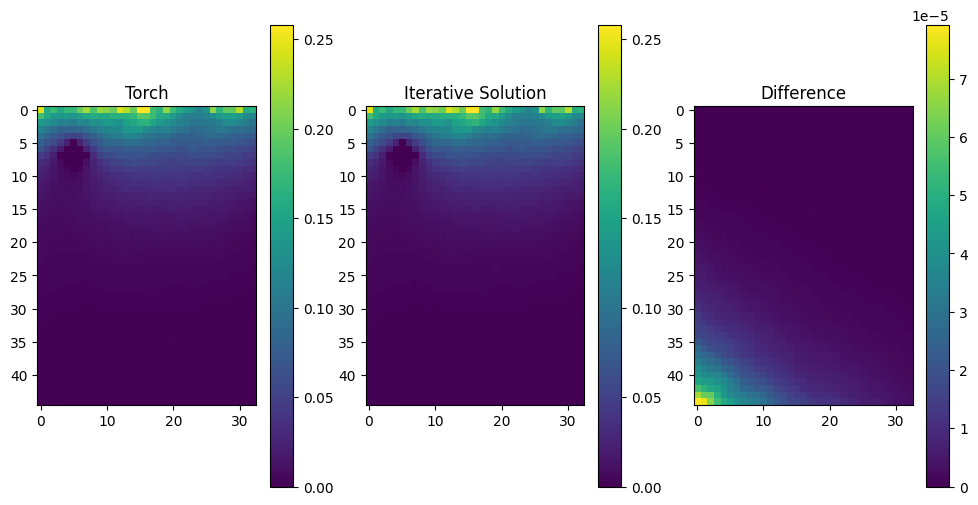

Test:    Torch Sol
Shape inv_sol: (2970,) max: 0.25824498176854216 min: 0.0


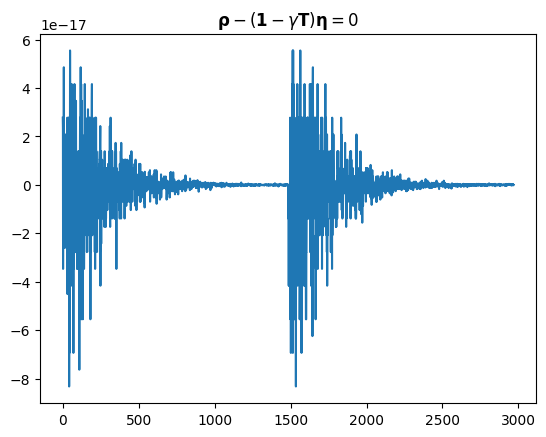

Passing test of solver True


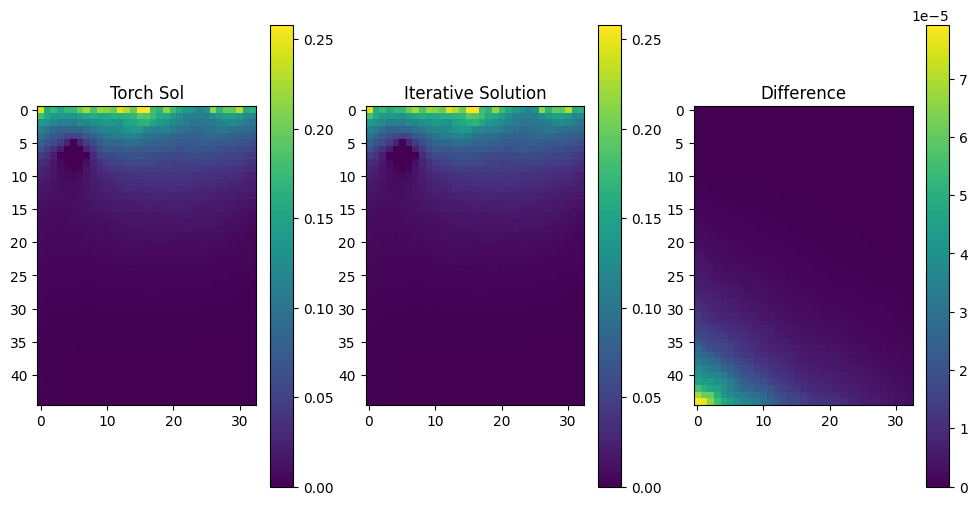

Test:      ScipySP
Shape inv_sol: (2970,) max: 0.2582449817685426 min: 0.0


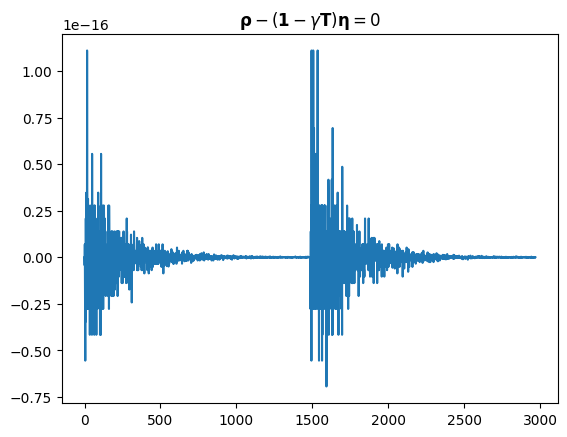

Passing test of solver True


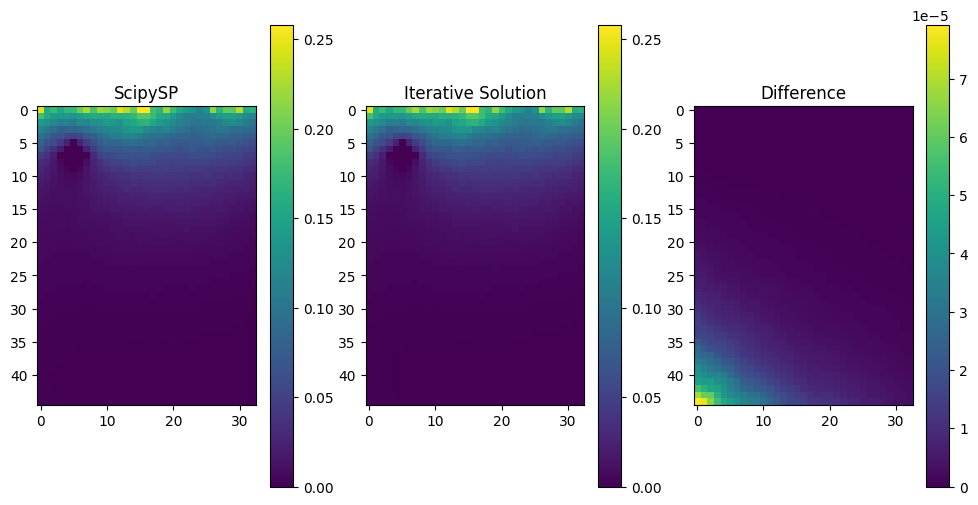

Test:        Petsc
Shape inv_sol: (2970,) max: 0.2582449817574165 min: 0.0


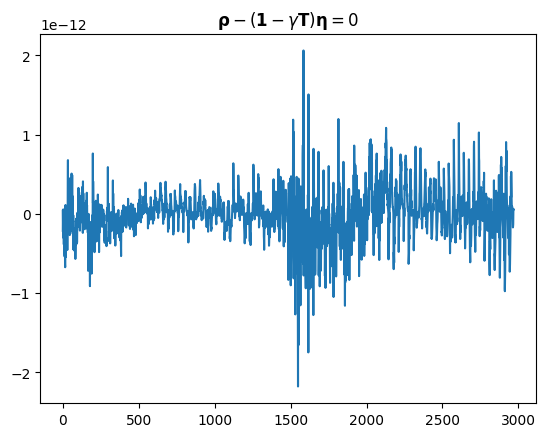

Passing test of solver True


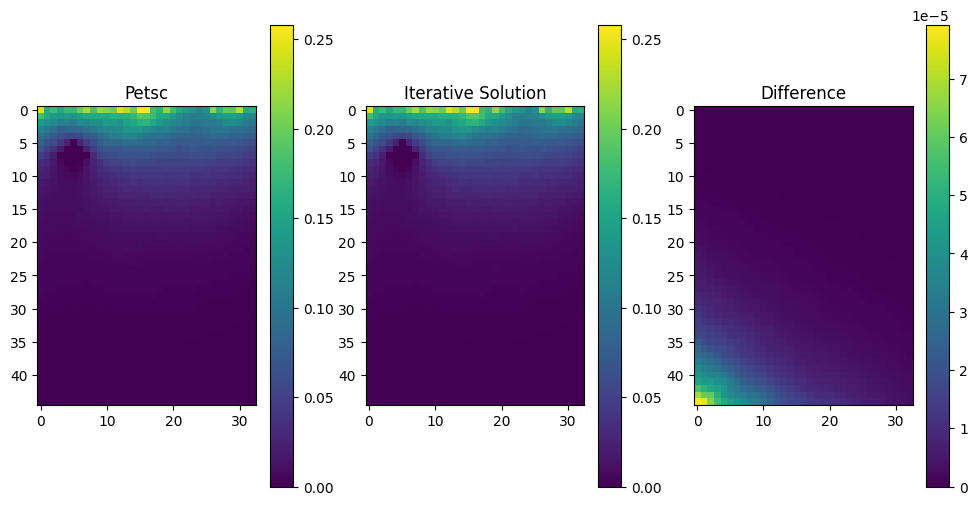

Difference between Numpy and Numpy Sol 3.237232530650669e-14


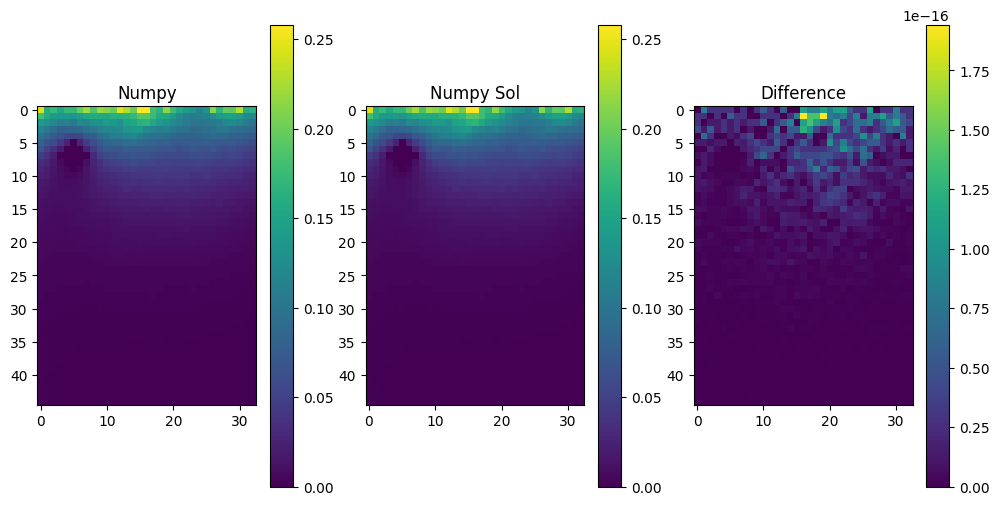

Difference between Numpy and Torch 8.184381991571676e-14


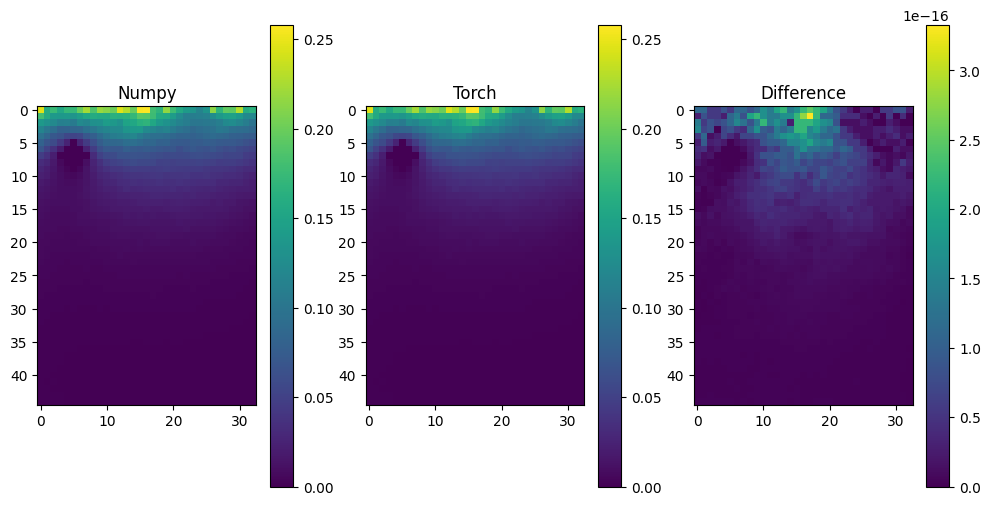

Difference between Numpy and Torch Sol 5.351876710898984e-14


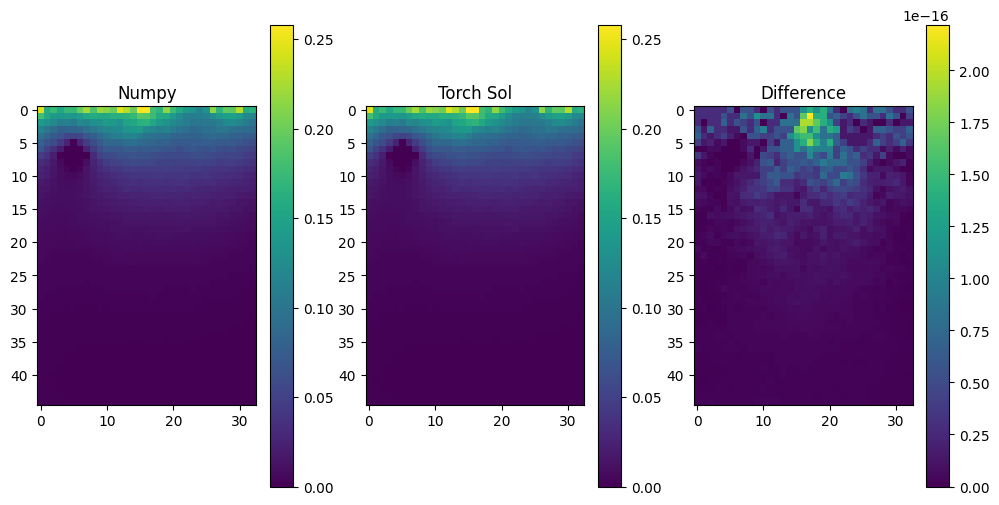

Difference between Numpy and ScipySP 1.276988497583842e-13


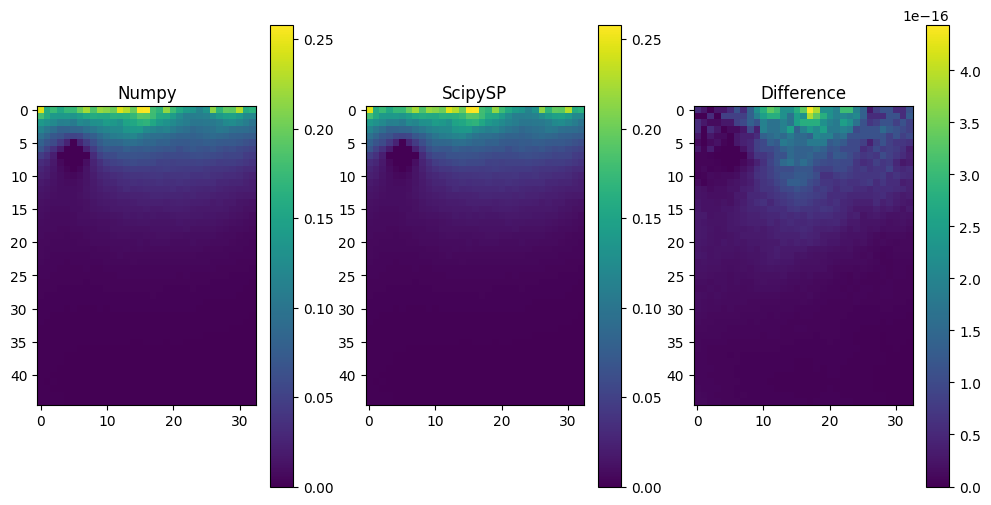

Difference between Numpy and Petsc 1.7182496512202147e-08


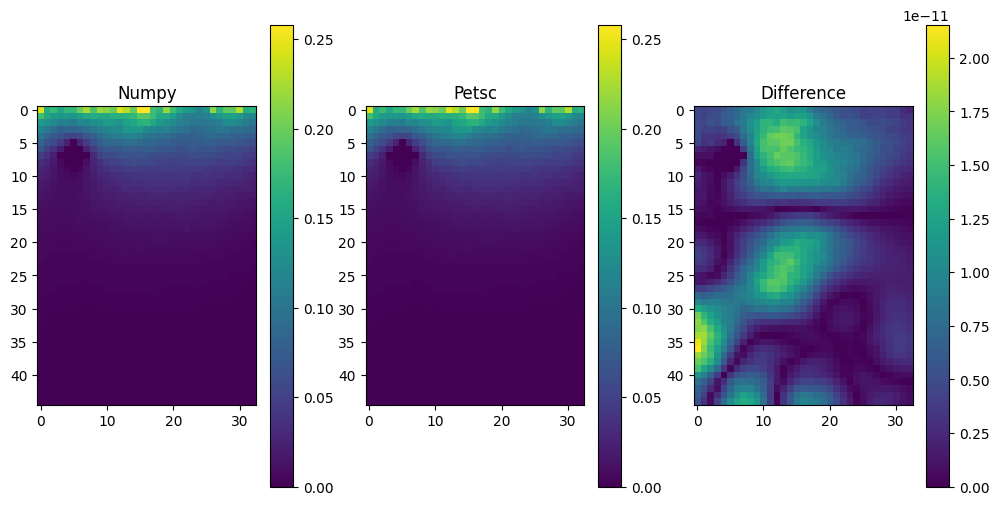

Difference between Numpy Sol and Torch 7.069095742801013e-14


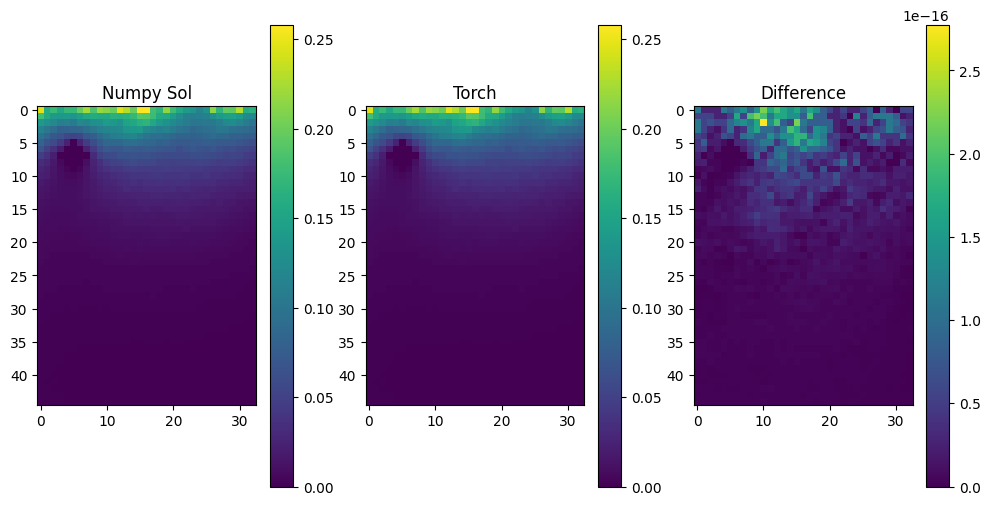

Difference between Numpy Sol and Torch Sol 4.7074811496822244e-14


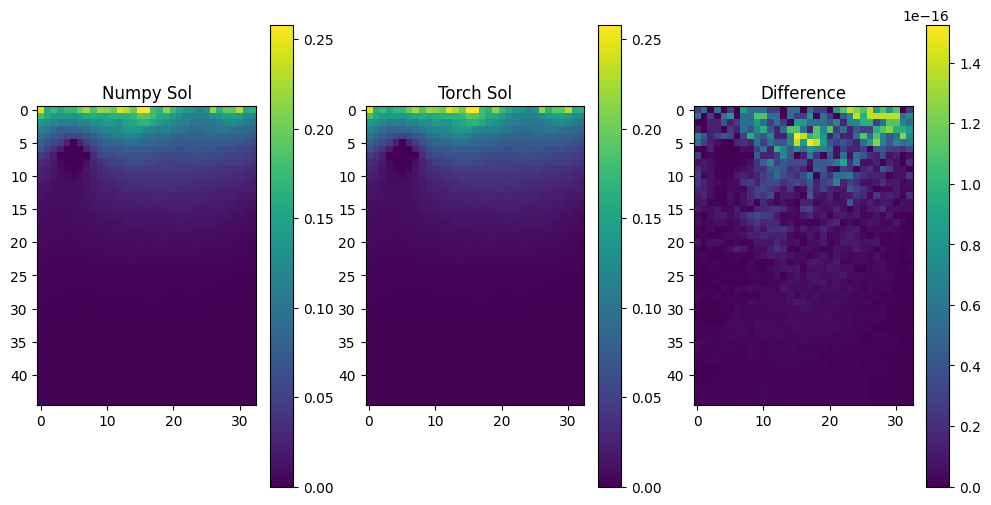

Difference between Numpy Sol and ScipySP 1.5071418505568923e-13


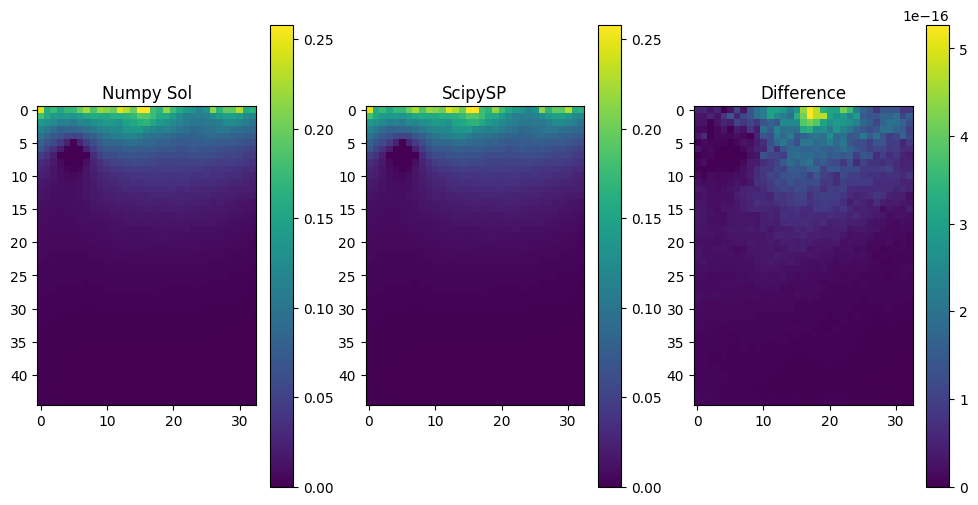

Difference between Numpy Sol and Petsc 1.7182477837361827e-08


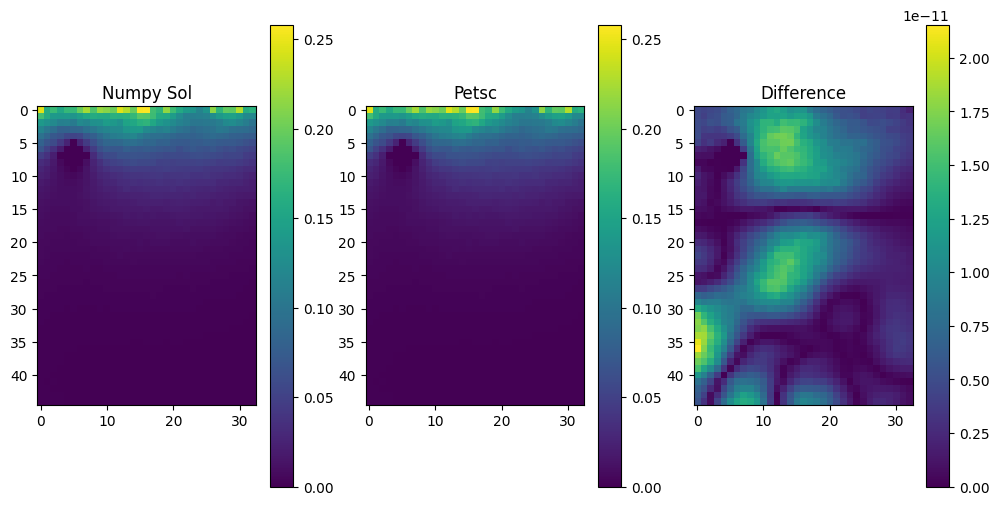

Difference between Torch and Torch Sol 4.082687963744003e-14


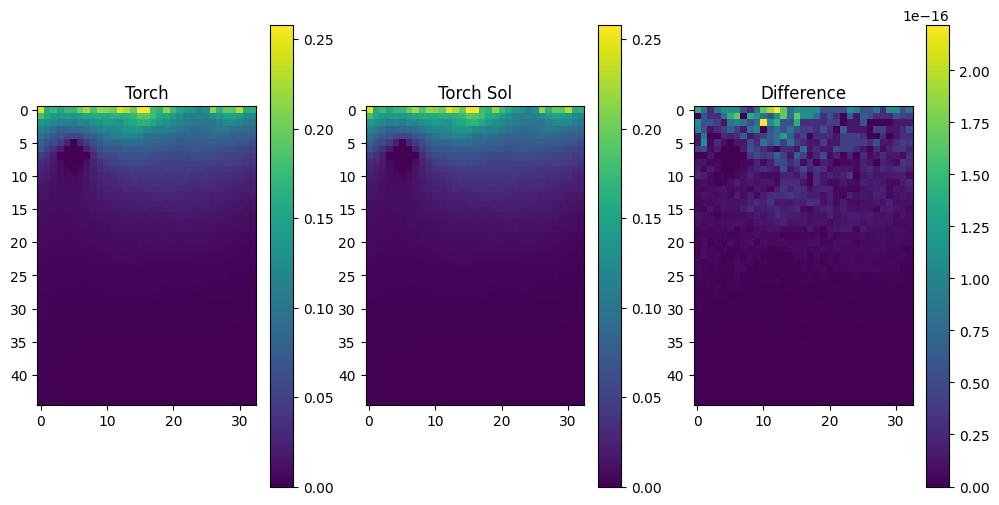

Difference between Torch and ScipySP 2.0420926234721026e-13


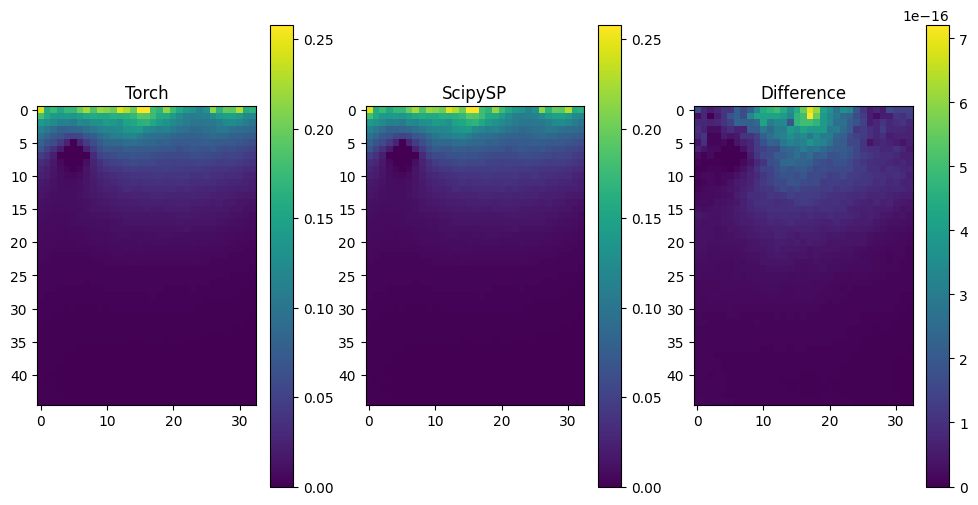

Difference between Torch and Petsc 1.7182446396040926e-08


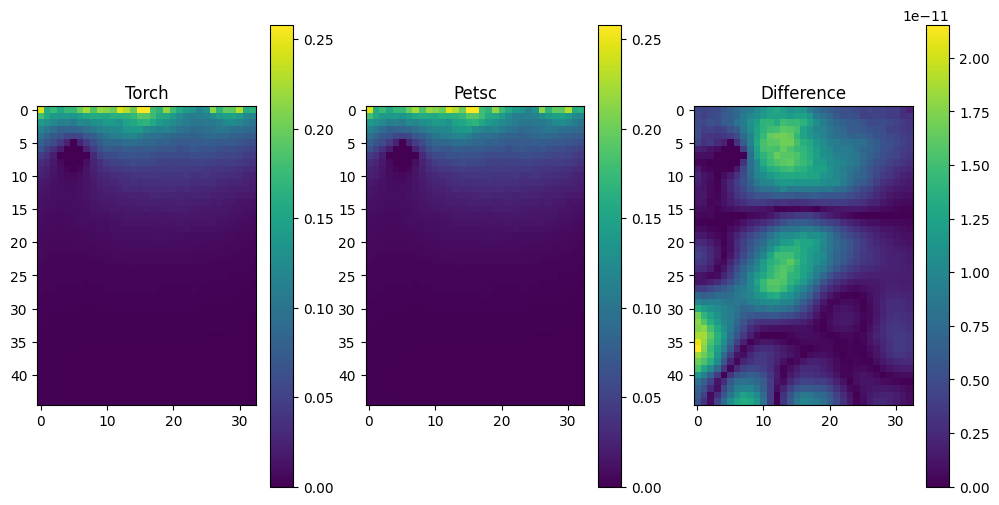

Difference between Torch Sol and ScipySP 1.6530673314571476e-13


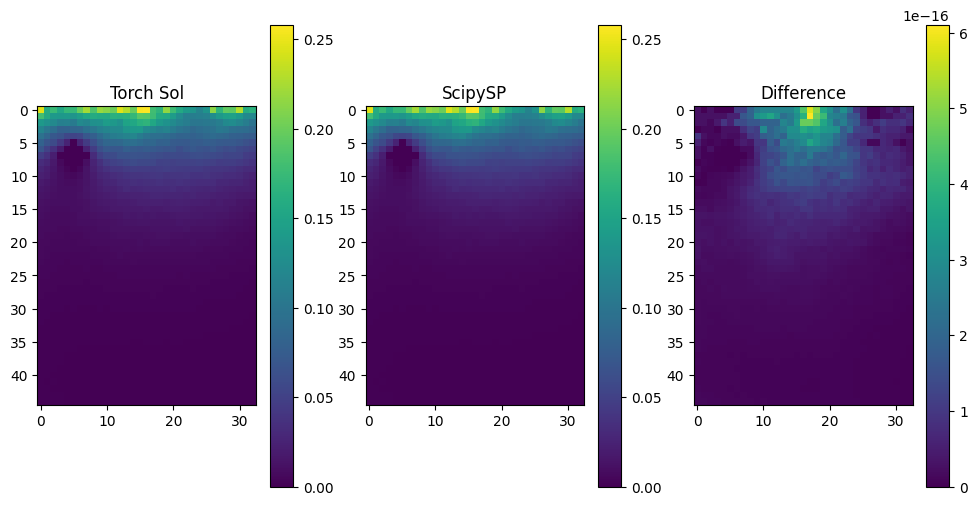

Difference between Torch Sol and Petsc 1.718247517851863e-08


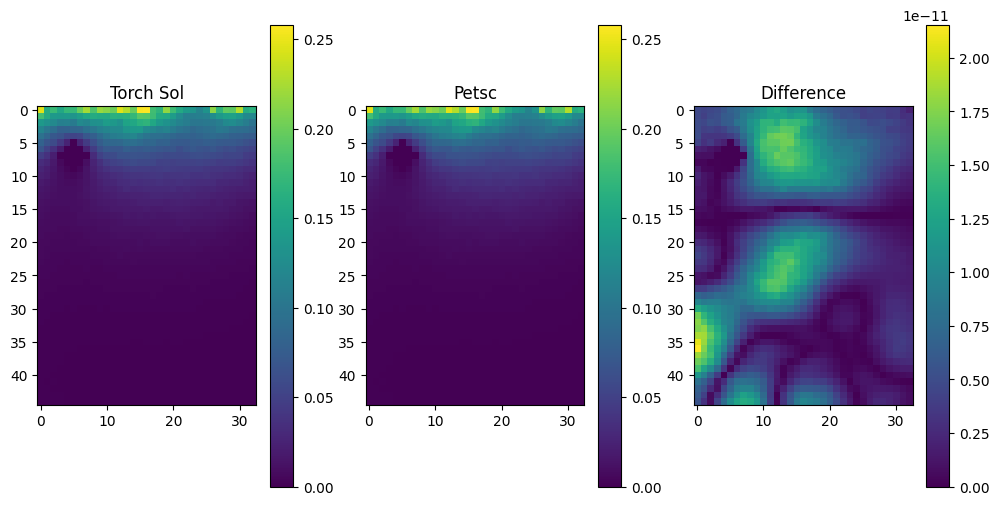

Difference between ScipySP and Petsc 1.7182575246313392e-08


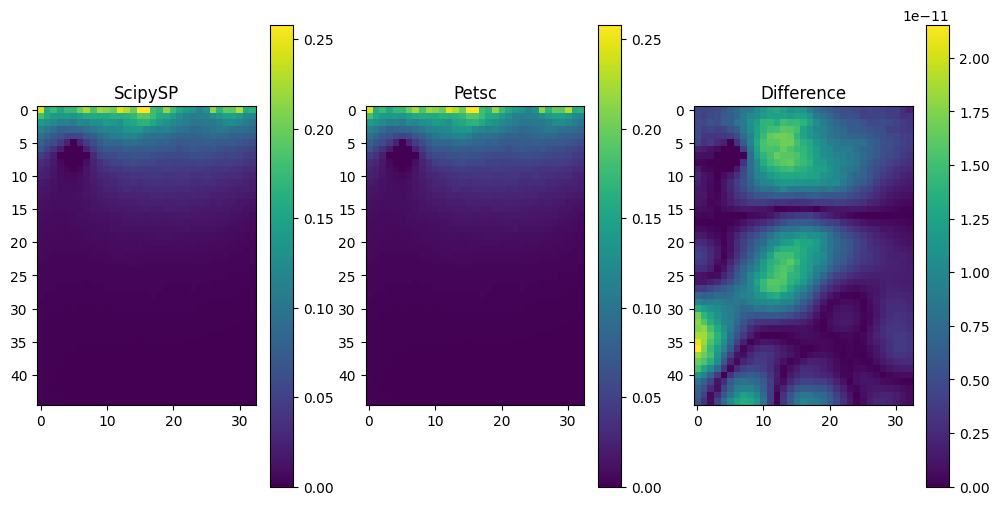

In [13]:

for solver, name_solver in zip(solvers, name_solvers):
    print("Test: {:>12}".format(name_solver))
    inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solver)
    print("Shape inv_sol:", inv_sol.shape, "max:", np.max(inv_sol), "min:", np.min(inv_sol))
    print("Passing test of solver",solution_test(inv_sol,T,rho0,gamma,plot=True))
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.title(name_solver)
    plt.imshow(inv_sol.reshape(M,Ly,Lx)[memory])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("Iterative Solution")
    plt.imshow(iter_sol.reshape(M,Ly,Lx)[memory])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Difference")
    plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[memory]-inv_sol.reshape(M,Ly,Lx)[memory]))
    plt.colorbar()
    plt.show()
    
for i in range(len(solvers)):
    for j in range(i+1,len(solvers)):
        inv_sol_i, T_i = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solvers[i])
        inv_sol_j, T_j = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range,func_eta=solvers[j])
        print("Difference between", name_solvers[i], "and", name_solvers[j], np.sum(np.abs(inv_sol_i-inv_sol_j)))

        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.title(name_solvers[i])
        plt.imshow(inv_sol_i.reshape(M,Ly,Lx)[memory])  
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.title(name_solvers[j])
        plt.imshow(inv_sol_j.reshape(M,Ly,Lx)[memory])
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.title("Difference")
        plt.imshow(np.abs(inv_sol_i.reshape(M,Ly,Lx)[memory]-inv_sol_j.reshape(M,Ly,Lx)[memory]))
        plt.colorbar()
        plt.show()
        
